In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rnapark","key":"f766d3a80003b91cb04f4e4633ffd077"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5760        117  1.0              
sadiajavedd/students-academic-performance-dataset             Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          11361        284  1.0              
kundanbedmutha/instagram-analytics-dataset                    Instagram Analytics Dataset                            1090208  2025-11-19 09:28:48.650000           1083         25  1.0              
sonalshind

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

plant_pathology_2020_fgvc7_path = kagglehub.competition_download('plant-pathology-2020-fgvc7')
rnapark_resnet18_f37072fd_pth_path = kagglehub.dataset_download('rnapark/resnet18-f37072fd-pth')
rnapark_resnet34_b627a593_pth_path = kagglehub.dataset_download('rnapark/resnet34-b627a593-pth')

print('Data source import complete.')


100%|██████████| 779M/779M [00:09<00:00, 83.0MB/s]

Extracting files...


100%|██████████| 41.4M/41.4M [00:01<00:00, 36.5MB/s]

Extracting files...


100%|██████████| 77.2M/77.2M [00:00<00:00, 135MB/s]

Extracting files...


Data source import complete.


# Load data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os

class AppleDataset(Dataset):
  def __init__(self, csv_path, images, transform=None, is_test=False):
    self.data = pd.read_csv(csv_path)
    self.images = images
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_path = os.path.join(self.images, row['image_id']+".jpg")
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      label = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype("float32")
      return image, label


# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# file paths
base_dir = plant_pathology_2020_fgvc7_path
train_csv = base_dir + "/train.csv"
test_csv  = base_dir + "/test.csv"
images = base_dir + "/images"

train_data = AppleDataset(train_csv, images, transform=None)
test_data  = AppleDataset(test_csv, images, transform=None, is_test=True)

## Helper to visualize training curves

In [ ]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Define training loop, evaluation loop

In [ ]:
# Define train/test loop

def mixup_data(x, y, alpha=0.2):
    # Returns mixed inputs, pairs of targets, and lambda
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        device,
        smoothing=0.02,
        grad_clip=1.0,
        use_mixup=True,
        mixup_alpha=0.2
    ):

    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().to(device)
        y_smooth = y * (1 - smoothing) + (1 - y) * smoothing

        # MixUp augmentation
        if use_mixup:
            X, y_a, y_b, lam = mixup_data(X, y_smooth, alpha=mixup_alpha)

            # Apply label smoothing AFTER mixup
            y_a = y_a * (1 - smoothing) + (1 - y_a) * smoothing
            y_b = y_b * (1 - smoothing) + (1 - y_b) * smoothing

            pred = model(X)
            loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
        else:
            # Only smoothing if NOT using mixup
            y_smooth = y * (1 - smoothing) + (1 - y) * smoothing
            pred = model(X)
            loss = loss_fn(pred, y_smooth)

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
def evaluate_model(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_predictions_sum = 0, 0
    num_labels = 4 # Number of output labels in our dataset

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X) # These are logits
        test_loss += loss_fn(pred, y).item()

        # Apply sigmoid to logits to get probabilities
        probabilities = torch.sigmoid(pred)
        # Threshold probabilities to get binary predictions (0 or 1)
        predicted_labels = (probabilities > 0.5).float()
        # Count total correct individual label predictions (TP + TN)
        correct_predictions_sum += (predicted_labels == y).float().sum().item()

    test_loss = test_loss / num_batches
    # Calculate overall accuracy as the ratio of correctly predicted individual labels
    # to the total possible individual labels (num_samples * num_labels)
    total_possible_labels = size * num_labels
    accuracy = correct_predictions_sum / total_possible_labels
    return test_loss, accuracy

def predict_loop(loader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities for each class

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_labels, dim=0), torch.cat(all_probs, dim=0)

def predict_test_loop(loader, model, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities

            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


# Baseline model - Transfer learning by feature extraction
- only changing the output layer of the model, leaving all parameters prior to the final layer unchanged
- freezing early layers and only training the final classifier

Data loaded successfully!
Train batches: 23
Val batches: 6
Test batches: 29
torch.Size([64, 3, 224, 224])
torch.Size([64, 4])
Using device: cuda

Epoch 1/15
-------------------------------
Training Loss:     0.5076
Validation Loss:   0.4123
Validation Acc:    0.8221
Validation Macro F1: 0.4386

Epoch 2/15
-------------------------------
Training Loss:     0.4125
Validation Loss:   0.2854
Validation Acc:    0.8922
Validation Macro F1: 0.5878

Epoch 3/15
-------------------------------
Training Loss:     0.3996
Validation Loss:   0.2655
Validation Acc:    0.9038
Validation Macro F1: 0.6063

Epoch 4/15
-------------------------------
Training Loss:     0.3628
Validation Loss:   0.2647
Validation Acc:    0.9045
Validation Macro F1: 0.6125

Epoch 5/15
-------------------------------
Training Loss:     0.4012
Validation Loss:   0.2762
Validation Acc:    0.8935
Validation Macro F1: 0.5939

Epoch 6/15
-------------------------------
Training Loss:     0.3699
Validation Loss:   0.2446
Validatio

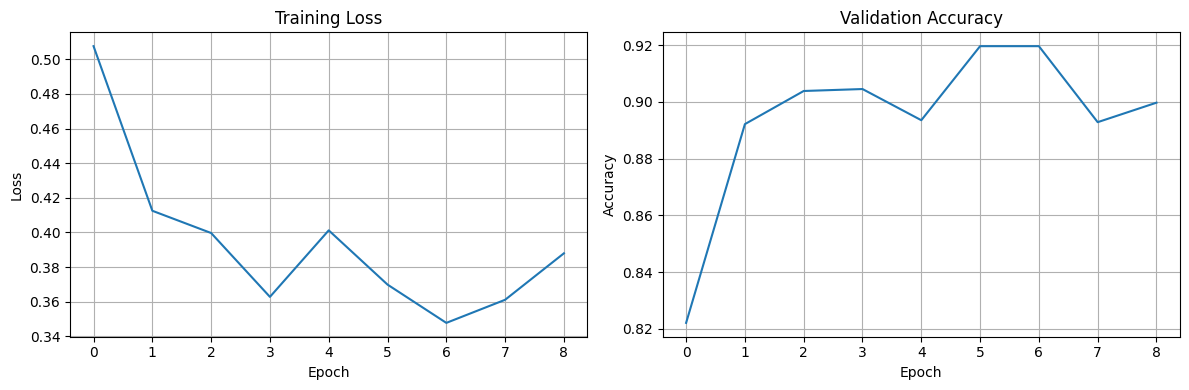


Baseline Model Results:
Best Validation Accuracy: 0.9196
Best Validation Macro F1: 0.6405
Final Validation Loss:    0.2735


In [ ]:
from torchvision import models, transforms
from sklearn.metrics import f1_score
import torch

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transform to datasets
train_data.transform = transform
test_data.transform = transform

train_set, val_set = random_split(train_data, [0.8, 0.2])

# Prepare DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Data loaded successfully!")
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

images, labels = next(iter(train_loader))
print(images.shape)  # (64, 3, H, W)
print(labels.shape)  # (64, 4)

model = models.resnet18(weights="DEFAULT")

# Load pretrained weights from Kaggle (offline)
#weights_file_path = os.path.join(rnapark_resnet18_f37072fd_pth_path, 'resnet18_f37072fd.pth')
#state_dict = torch.load(weights_file_path, map_location="cpu")
#model.load_state_dict(state_dict)

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace classification head for 4 outputs
model.fc = torch.nn.Linear(model.fc.in_features, 4)

# Loss + Optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

epochs = 15
patience = 3
best_val_accuracy = 0
epochs_without_improvement = 0

for t in range(epochs):
    print(f"\nEpoch {t+1}/{epochs}")
    print("-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)

    val_loss, val_accuracy = evaluate_model(val_loader, model, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    y_true, y_probs = predict_loop(val_loader, model, device)
    y_pred = (y_probs.cpu().numpy() >= 0.5).astype(int)
    true_np = y_true.cpu().numpy()

    val_f1 = f1_score(true_np, y_pred, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Training Loss:     {train_loss:.4f}")
    print(f"Validation Loss:   {val_loss:.4f}")
    print(f"Validation Acc:    {val_accuracy:.4f}")
    print(f"Validation Macro F1: {val_f1:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {t+1}")
            break

# Plot curves
plot_training_curves(train_losses, val_accuracies)

print("\nBaseline Model Results:")
print(f"Best Validation Accuracy: {max(val_accuracies):.4f}")
print(f"Best Validation Macro F1: {max(val_f1_scores):.4f}")
print(f"Final Validation Loss:    {val_losses[-1]:.4f}")